In [1]:
from Config.config import CONFIG
CONFIG = CONFIG("Reddit")

In [2]:
from DyGLib.models.GraphMixer import GraphMixer
from DyGLib.models.TGAT import TGAT
from DyGLib.models.TCL import TCL
from DyGLib.models.CAWN import CAWN
from DyGLib.models.DyGFormer import DyGFormer
from DyGLib.models.MemoryModel import MemoryModel, compute_src_dst_node_time_shifts

from DyGLib.models.modules import TGNN, NeuralNetworkSrcDst, BatchSubgraphs
from DyGLib.utils.DataLoader import get_link_prediction_data
from DyGLib.utils.utils import get_neighbor_sampler, NegativeEdgeSampler

import torch
import numpy as np
import pandas as pd
import seaborn as sns

import random

import graphviz
from IPython.display import SVG
import time

# Initialization

In [3]:
trained_model_path = CONFIG.model.trained_model_path
edge_feat_path = CONFIG.data.folder + CONFIG.data.edge_feat_file
node_feat_path = CONFIG.data.folder + CONFIG.data.node_feat_file
index_path = CONFIG.data.folder + CONFIG.data.index_file
feature_names_path = CONFIG.data.folder + CONFIG.data.feature_names_file

In [4]:
# get data for training, validation and testing
node_raw_features, edge_raw_features, full_data, train_data, val_data, test_data = \
    get_link_prediction_data(val_ratio=0.1, test_ratio=0.1, node_dim=CONFIG.model.node_dim)

# initialize validation and test neighbor sampler to retrieve temporal graph
full_neighbor_sampler = get_neighbor_sampler(data=full_data, edge_features=edge_raw_features, sample_neighbor_strategy=CONFIG.model.sample_neighbor_strategy,
                                                time_scaling_factor=CONFIG.model.time_scaling_factor, seed=1)
train_neighbor_sampler = get_neighbor_sampler(data=train_data, edge_features=edge_raw_features, sample_neighbor_strategy=CONFIG.model.sample_neighbor_strategy,
                                                time_scaling_factor=CONFIG.model.time_scaling_factor, seed=1)

# create model
if CONFIG.model.model_name == 'TGAT':
    dynamic_backbone = TGAT(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name in ['JODIE', 'DyRep', 'TGN']:
    # four floats that represent the mean and standard deviation of source and destination node time shifts in the training data, which is used for JODIE
    src_node_mean_time_shift, src_node_std_time_shift, dst_node_mean_time_shift_dst, dst_node_std_time_shift = \
        compute_src_dst_node_time_shifts(train_data.src_node_ids, train_data.dst_node_ids, train_data.node_interact_times)
    dynamic_backbone = MemoryModel(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                                    time_feat_dim=CONFIG.model.time_feat_dim, model_name=CONFIG.model.model_name, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads,
                                    dropout=CONFIG.model.dropout, src_node_mean_time_shift=src_node_mean_time_shift, src_node_std_time_shift=src_node_std_time_shift,
                                    dst_node_mean_time_shift_dst=dst_node_mean_time_shift_dst, dst_node_std_time_shift=dst_node_std_time_shift, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'CAWN':
    dynamic_backbone = CAWN(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, position_feat_dim=CONFIG.model.position_feat_dim, walk_length=CONFIG.model.walk_length,
                            num_walk_heads=CONFIG.model.num_walk_heads, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'TCL':
    dynamic_backbone = TCL(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads,
                            num_depths=CONFIG.model.num_neighbors + 1, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'GraphMixer':
    dynamic_backbone = GraphMixer(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                            time_feat_dim=CONFIG.model.time_feat_dim, num_tokens=CONFIG.model.num_neighbors, num_layers=CONFIG.model.num_layers, dropout=CONFIG.model.dropout, device=CONFIG.model.device)
elif CONFIG.model.model_name == 'DyGFormer':
    dynamic_backbone = DyGFormer(num_nodes=node_raw_features.shape[0], node_dim=node_raw_features.shape[1], edge_dim=edge_raw_features.shape[1],
                                    time_feat_dim=CONFIG.model.time_feat_dim, channel_embedding_dim=CONFIG.model.channel_embedding_dim, patch_size=CONFIG.model.patch_size,
                                    num_layers=CONFIG.model.num_layers, num_heads=CONFIG.model.num_heads, dropout=CONFIG.model.dropout,
                                    max_input_sequence_length=CONFIG.model.max_input_sequence_length, device=CONFIG.model.device)
else:
    raise ValueError(f"Wrong value for model_name {CONFIG.model.model_name}!")

regressor = NeuralNetworkSrcDst(input_dim=node_raw_features.shape[1], num_layers=CONFIG.model.num_reg_layers, hidden_dim=CONFIG.model.hidden_reg_layers_dim)
model = TGNN(dynamic_backbone, regressor)

The dataset has 672447 interactions, involving 10984 different nodes
The training dataset has 435435 interactions, involving 9633 different nodes
The validation dataset has 67245 interactions, involving 9242 different nodes
The test dataset has 67245 interactions, involving 9028 different nodes
The new node validation dataset has 14378 interactions, involving 3239 different nodes
The new node test dataset has 14782 interactions, involving 3151 different nodes
1098 nodes were used for the inductive testing, i.e. are never seen during training


In [5]:
model.load_state_dict(torch.load(trained_model_path, weights_only=True))
model.to(CONFIG.model.device)
model.eval()

TGNN(
  (backbone): TGAT(
    (time_encoder): TimeEncoder(
      (w): Linear(in_features=1, out_features=100, bias=True)
    )
    (temporal_conv_layers): ModuleList(
      (0-1): 2 x MultiHeadAttention(
        (query_projection): Linear(in_features=272, out_features=272, bias=False)
        (key_projection): Linear(in_features=444, out_features=272, bias=False)
        (value_projection): Linear(in_features=444, out_features=272, bias=False)
        (layer_norm): LayerNorm((272,), eps=1e-05, elementwise_affine=True)
        (residual_fc): Linear(in_features=272, out_features=272, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (projectors): ModuleList(
      (0-1): 2 x Linear(in_features=444, out_features=172, bias=True)
    )
  )
  (model): NeuralNetworkSrcDst(
    (model): Sequential(
      (0): Linear(in_features=344, out_features=172, bias=True)
      (1): ReLU()
      (2): Linear(in_features=172, out_features=1, bias=True)
    )
  )
)

## Select edges

In [6]:
num_samples = 200

In [7]:
def get_edge_by_id(link_index):
    src, dst, time_stamp, edge_id, true_value = full_data.src_node_ids[link_index], full_data.dst_node_ids[link_index], full_data.node_interact_times[link_index], full_data.edge_ids[link_index], 1 # type: ignore
    return src, dst, time_stamp, edge_id, true_value

In [8]:
random.seed(2025)

sampled_edge_ids = random.sample((np.where((~np.isnan(full_data.labels)) & (~np.isin(full_data.edge_ids, train_data.edge_ids)))[0]).tolist(), num_samples)

edge_info_array = np.array([list(get_edge_by_id(i)) for i in sampled_edge_ids])
edge_info = pd.DataFrame(edge_info_array, columns=["Src", "Dst", "Time", "Edge", "Target"])

edges = edge_info["Edge"].to_numpy(dtype=int)

edge_info["InTrain"] = np.isin(edges, train_data.edge_ids)
edge_info = edge_info.sort_values(by="InTrain").reset_index(drop=True)
edge_info = edge_info[edge_info.InTrain == False]

srcs = edge_info["Src"].to_numpy(dtype=int)
dsts = edge_info["Dst"].to_numpy(dtype=int)
timestamps = edge_info["Time"].to_numpy(dtype="float32")
targets = edge_info["Target"].to_numpy(dtype="float32")

In [9]:
model.eval()

subgraphs_src = full_neighbor_sampler.get_multi_hop_neighbors(CONFIG.model.num_layers, srcs, timestamps, num_neighbors = CONFIG.model.num_neighbors)
subgraphs_dst = full_neighbor_sampler.get_multi_hop_neighbors(CONFIG.model.num_layers, dsts, timestamps, num_neighbors = CONFIG.model.num_neighbors)
edge_feat_src = full_neighbor_sampler.get_edge_features_for_multi_hop(subgraphs_src[1])
edge_feat_dst = full_neighbor_sampler.get_edge_features_for_multi_hop(subgraphs_dst[1])

subgraphs_src = BatchSubgraphs(*subgraphs_src, edge_feat_src)
subgraphs_src.to(CONFIG.model.device)
subgraphs_dst = BatchSubgraphs(*subgraphs_dst, edge_feat_dst)
subgraphs_dst.to(CONFIG.model.device)

predicts = model(src_node_ids=srcs,
                dst_node_ids=dsts,
                node_interact_times=timestamps,
                src_subgraphs = subgraphs_src,
                dst_subgraphs = subgraphs_dst,
                time_gap=CONFIG.model.time_gap,
                edges_are_positive=True).squeeze(dim=-1).sigmoid()

edge_info["Prediction"] = predicts.detach().cpu().numpy()
edge_info

,Src,Dst,Time,Edge,Target,InTrain,Prediction
0,4632.0,10006.0,2303458.287,581647.0,1.0,False,0.998957
1,9969.0,10468.0,2315471.742,585177.0,1.0,False,0.872449
2,870.0,10006.0,907622.387,218998.0,1.0,False,0.958358
3,2807.0,10212.0,2242424.197,567113.0,1.0,False,0.940202
4,7179.0,10017.0,2105738.914,529198.0,1.0,False,0.999339
...,...,...,...,...,...,...,...
195,8063.0,10042.0,1798406.448,451096.0,1.0,False,0.998824
196,1631.0,10007.0,2272826.027,573691.0,1.0,False,0.979122
197,6197.0,10153.0,2194095.089,552524.0,1.0,False,0.992656
198,9290.0,10105.0,2544225.219,636006.0,1.0,False,0.998997


In [10]:
timings = []

# Shapley values - Edge level

In [11]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerEvents
import shap

c:\Users\LMS\Documents\Masterarbeit\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
explainer = ShapleyExplainerEvents(model, full_neighbor_sampler, full_data, edge_raw_features)

In [13]:
start = time.time_ns()
explainer.initialize()
end = time.time_ns()
timings.append(np.array([[end-start, "Shapley4TGNNEdge", "Init"]]))

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
result_shapley_edge, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "Shapley4TGNNEdge"), np.full(exec_times.shape, "Explain")]))
result_shapley_edge["Explainer"] = "Shapley4TGNNEdge"
result_shapley_edge

 66%|██████▌   | 132/200 [17:39<04:41,  4.14s/it] 

Exception for 390 to 10176 at 2859.282958984375 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\Shapley4TGNN\Explainer.py", line 90, in explain_instance
    assert len(event_ids) != 0, "The computational subgraph contains no events!"
AssertionError: The computational subgraph contains no events!



100%|██████████| 200/200 [22:20<00:00,  6.70s/it]


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.912,1.000,0.672,0.000,-0.313,-3.253,-0.328,0.000,Zero,Shapley4TGNNEdge
1,0.912,1.000,0.672,0.001,-0.313,-3.253,-0.328,0.000,Zero,Shapley4TGNNEdge
2,0.912,1.000,0.672,0.001,-0.313,-3.253,-0.328,0.000,Zero,Shapley4TGNNEdge
3,0.912,1.000,0.664,0.002,-0.304,-3.121,-0.336,0.000,Zero,Shapley4TGNNEdge
4,0.912,1.000,0.673,0.002,-0.282,-2.901,-0.327,0.000,Zero,Shapley4TGNNEdge
...,...,...,...,...,...,...,...,...,...,...
47,0.912,1.000,0.912,0.998,-0.008,0.010,-0.088,0.751,Mean,Shapley4TGNNEdge
48,0.912,1.000,0.913,0.998,-0.005,0.018,-0.087,0.833,Mean,Shapley4TGNNEdge
49,0.912,1.000,0.914,0.999,-0.003,0.018,-0.086,0.921,Mean,Shapley4TGNNEdge
50,0.912,1.000,0.914,0.999,-0.003,0.018,-0.086,0.921,Mean,Shapley4TGNNEdge


In [15]:
explainer = None
torch.cuda.empty_cache()

# Shapley values - Feature level

In [16]:
from Explainers.Shapley4TGNN.Explainer import ShapleyExplainerFeatures
from Explainers.Shapley4TGNN.Plots import waterfall
import shap
from shap import Explanation

In [17]:
explainer = ShapleyExplainerFeatures(model, full_neighbor_sampler, full_data, edge_raw_features, None, shapley_alg="MonteCarlo", top_k=4)

In [18]:
start = time.time_ns()
explainer.initialize()
end = time.time_ns()
timings.append(np.array([[end-start, "Shapley4TGNNFeature", "Init"]]))

In [19]:
result_shapley_feat, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "Shapley4TGNNFeature"), np.full(exec_times.shape, "Explain")]))
result_shapley_feat["Explainer"] = "Shapley4TGNNFeature"
result_shapley_feat

 66%|██████▌   | 132/200 [11:39:29<6:05:24, 322.43s/it]

Exception for 390 to 10176 at 2859.282958984375 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\Shapley4TGNN\Explainer.py", line 258, in explain_instance
    assert len(event_ids) != 0, "The computational subgraph contains no events!"
AssertionError: The computational subgraph contains no events!



100%|██████████| 200/200 [17:35:50<00:00, 316.75s/it]  


,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.912,1.000,0.705,0.000,-0.288,-3.030,-0.295,0.000,Zero,Shapley4TGNNFeature
1,0.912,1.000,0.856,0.002,-0.120,-1.587,-0.144,0.001,Zero,Shapley4TGNNFeature
2,0.912,1.000,0.858,0.003,-0.120,-1.566,-0.142,0.001,Zero,Shapley4TGNNFeature
3,0.912,1.000,0.859,0.004,-0.120,-1.563,-0.141,0.001,Zero,Shapley4TGNNFeature
4,0.912,1.000,0.861,0.005,-0.120,-1.555,-0.139,0.001,Zero,Shapley4TGNNFeature
...,...,...,...,...,...,...,...,...,...,...
47,0.912,1.000,0.908,0.995,-0.011,-0.008,-0.092,0.433,Mean,Shapley4TGNNFeature
48,0.912,1.000,0.912,0.996,-0.007,0.018,-0.088,0.774,Mean,Shapley4TGNNFeature
49,0.912,1.000,0.912,0.997,-0.005,0.002,-0.088,0.850,Mean,Shapley4TGNNFeature
50,0.912,1.000,0.913,0.998,-0.003,0.006,-0.087,0.933,Mean,Shapley4TGNNFeature


In [20]:
explainer = None
torch.cuda.empty_cache()

# TGNN Explainer

In [21]:
from Explainers.External.tgnnexplainer.Explainer import SubgraphXTExplainer

In [22]:
explainer = SubgraphXTExplainer(model, full_neighbor_sampler, full_data)

In [23]:
timings.append(np.array([[0, "TGNNExplainer", "Init"]]))

In [24]:
result_tgnnexpl, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "TGNNExplainer"), np.full(exec_times.shape,"Explain")]))
result_tgnnexpl["Explainer"] = "TGNNExplainer"
result_tgnnexpl

  0%|          | 0/200 [00:00<?, ?it/s]

Exception for 4632 to 10006 at 2303458.25 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\Explainer.py", line 66, in explain_instance
    explain_results = self.explainer(event_idxs=int(edge_id))
TypeError: only length-1 arrays can be converted to Python scalars

Exception for 9969 to 10468 at 2315471.75 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\Explainer.py", line 66, in explain_instance
    explain_results = self.explainer(event_idxs=int(edge_id))
TypeError: only length-1 arrays can be converted t

  6%|▋         | 13/200 [04:09<59:47, 19.18s/it]

Exception for 8730 to 10318 at 2671918.75 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\Explainer.py", line 66, in explain_instance
    explain_results = self.explainer(event_idxs=int(edge_id))
TypeError: only length-1 arrays can be converted to Python scalars

Exception for 7829 to 10011 at 2317768.25 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\Explainer.py", line 66, in explain_instance
    explain_results = self.explainer(event_idxs=int(edge_id))
TypeError: only length-1 arrays can be converted t

100%|██████████| 200/200 [06:22<00:00,  1.91s/it]

Exception for 555 to 10032 at 2449500.75 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\Explainer.py", line 66, in explain_instance
    explain_results = self.explainer(event_idxs=int(edge_id))
TypeError: only length-1 arrays can be converted to Python scalars

Exception for 8142 to 10105 at 820125.375 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\tgnnexplainer\Explainer.py", line 66, in explain_instance
    explain_results = self.explainer(event_idxs=int(edge_id))
TypeError: only length-1 arrays can be converted to

,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.964,1.000,0.696,0.000,-0.274,-2.788,-0.304,0.786,Zero,TGNNExplainer
1,0.964,1.000,0.696,0.001,-0.274,-2.788,-0.304,0.786,Zero,TGNNExplainer
2,0.964,1.000,0.696,0.001,-0.274,-2.788,-0.304,0.786,Zero,TGNNExplainer
3,0.964,1.000,0.696,0.002,-0.274,-2.788,-0.304,0.786,Zero,TGNNExplainer
4,0.964,1.000,0.696,0.002,-0.274,-2.788,-0.304,0.786,Zero,TGNNExplainer
...,...,...,...,...,...,...,...,...,...,...
47,0.964,1.000,0.963,0.998,-0.002,0.125,-0.037,1.000,Mean,TGNNExplainer
48,0.964,1.000,0.963,0.998,-0.002,0.125,-0.037,1.000,Mean,TGNNExplainer
49,0.964,1.000,0.963,0.999,-0.002,0.125,-0.037,1.000,Mean,TGNNExplainer
50,0.964,1.000,0.963,0.999,-0.002,0.125,-0.037,1.000,Mean,TGNNExplainer


In [25]:
explainer = None
torch.cuda.empty_cache()

# TempME

In [26]:
from Explainers.External.TempME.Explainer import TempMEExplainer
from Explainers.External.TempME.utils.graph import get_walk_finder

In [27]:
preprocessing = True

In [28]:
# Preprocessing
if(preprocessing):
    # Preprocessing train data
    explainer = TempMEExplainer(model, train_neighbor_sampler, train_data)
    walk_finder = get_walk_finder(train_data)
    neg_edge_sampler = NegativeEdgeSampler(train_data.src_node_ids, train_data.dst_node_ids, train_data.node_interact_times)

    explainer.preprocess(walk_finder, neg_edge_sampler, train=True)
    # Training
    explainer.initialize(train = True)
    # Preprocessing full data
    explainer = TempMEExplainer(model, full_neighbor_sampler, full_data)
    walk_finder = get_walk_finder(full_data)
    neg_edge_sampler = NegativeEdgeSampler(full_data.src_node_ids, full_data.dst_node_ids, full_data.node_interact_times)

    explainer.preprocess(walk_finder, neg_edge_sampler, train=False)

start extracting subgraph


100%|██████████| 435435/435435 [3:21:38<00:00, 35.99it/s]  


done


100%|██████████| 435435/435435 [01:39<00:00, 4390.03it/s]


num of training instances: 435435
num of batches per epoch: 871


100%|██████████| 871/871 [36:21<00:00,  2.50s/it]


Training Epoch: 0 | Training loss: -20.22291105294474 | Pred loss: -19.96139004309881 | KL loss: -0.52304200443143 | 


100%|██████████| 871/871 [37:12<00:00,  2.56s/it]


Training Epoch: 1 | Training loss: -20.223701823045136 | Pred loss: -19.961796203245388 | KL loss: -0.5238110410085912 | 


100%|██████████| 871/871 [37:30<00:00,  2.58s/it]


Training Epoch: 2 | Training loss: -20.217413099707198 | Pred loss: -19.95550804926525 | KL loss: -0.5238104811628979 | 


100%|██████████| 871/871 [37:16<00:00,  2.57s/it]


Training Epoch: 3 | Training loss: -20.2205442238073 | Pred loss: -19.958639199643404 | KL loss: -0.5238104823262492 | 


100%|██████████| 871/871 [36:59<00:00,  2.55s/it]


Training Epoch: 4 | Training loss: -20.218071708722995 | Pred loss: -19.956165891837855 | KL loss: -0.5238114991636966 | 


100%|██████████| 871/871 [36:48<00:00,  2.54s/it]


Training Epoch: 5 | Training loss: -20.216679734012153 | Pred loss: -19.954773242657 | KL loss: -0.5238124418888246 | 


100%|██████████| 871/871 [36:56<00:00,  2.55s/it]


Training Epoch: 6 | Training loss: -20.21532779172422 | Pred loss: -19.953420974083254 | KL loss: -0.5238131423631573 | 


100%|██████████| 871/871 [36:54<00:00,  2.54s/it]


Training Epoch: 7 | Training loss: -20.207362734491323 | Pred loss: -19.945455586184863 | KL loss: -0.5238138109479789 | 


100%|██████████| 871/871 [37:12<00:00,  2.56s/it]


Training Epoch: 8 | Training loss: -20.210141088877698 | Pred loss: -19.948233745675683 | KL loss: -0.5238142618492468 | 


100%|██████████| 871/871 [36:42<00:00,  2.53s/it]


Training Epoch: 9 | Training loss: -20.213694501279004 | Pred loss: -19.951787061724133 | KL loss: -0.5238145414641475 | 
start extracting subgraph


100%|██████████| 672447/672447 [21:02:05<00:00,  8.88it/s]   


done


100%|██████████| 672447/672447 [02:53<00:00, 3873.27it/s]


In [29]:
explainer = TempMEExplainer(model, full_neighbor_sampler, full_data)

In [30]:
# Interference
start = time.time_ns()
explainer = TempMEExplainer(model, full_neighbor_sampler, full_data)
explainer.initialize(train = False)
end = time.time_ns()
timings.append(np.array([[end-start, "TempME", "Init"]]))

In [31]:
result_tempme, exec_times = explainer.evaluate(srcs, dsts, timestamps, targets, edge_raw_features)
timings.append(np.hstack([exec_times, np.full(exec_times.shape, "TempME"), np.full(exec_times.shape, "Explain")]))
result_tempme["Explainer"] = "TempME"
result_tempme

  0%|          | 1/200 [00:00<00:34,  5.85it/s]

Exception for 4632 to 10006 at 2303458.25 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 9969 to 10468 at 2315471.75 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 870 to 10006 at 907622.375 occured

 17%|█▋        | 34/200 [00:04<00:17,  9.61it/s]

Exception for 8730 to 10318 at 2671918.75 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 7829 to 10011 at 2317768.25 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 9164 to 10047 at 2149591.5 occured

 39%|███▉      | 78/200 [00:04<00:03, 30.69it/s]

Exception for 6583 to 10003 at 1316827.125 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 1145 to 10036 at 2355200.75 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 2247 to 10057 at 2525270.0 occure

 58%|█████▊    | 117/200 [00:06<00:03, 25.07it/s]

Exception for 555 to 10032 at 2449500.75 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 8142 to 10105 at 820125.375 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 9728 to 10177 at 2499966.5 occured:

 82%|████████▏ | 163/200 [00:07<00:00, 51.19it/s]

Exception for 7313 to 10027 at 406371.375 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 5238 to 10053 at 2099774.75 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 4503 to 10055 at 2143607.0 occured

100%|██████████| 200/200 [00:07<00:00, 27.85it/s]

Exception for 3594 to 10020 at 519162.0 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 97 to 10007 at 2330496.75 occured: Traceback (most recent call last):
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\utils.py", line 127, in evaluate
    explanation = self.explain_instance(src[i], dst[i], timestamp[i], silent=True)
  File "c:\Users\LMS\Documents\Masterarbeit\Explainers\External\TempME\Explainer.py", line 197, in explain_instance
    edge_id = self.data.edge_ids[mask][0]
IndexError: index 0 is out of bounds for axis 0 with size 0

Exception for 4812 to 10003 at 2411284.5 occured: Tr

,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.994,1.000,0.623,0.000,-0.371,-4.581,-0.377,0.769,Zero,TempME
1,0.994,1.000,0.623,0.001,-0.371,-4.581,-0.377,0.769,Zero,TempME
2,0.994,1.000,0.623,0.001,-0.371,-4.581,-0.377,0.769,Zero,TempME
3,0.994,1.000,0.661,0.002,-0.334,-4.430,-0.339,0.831,Zero,TempME
4,0.994,1.000,0.661,0.002,-0.334,-4.430,-0.339,0.831,Zero,TempME
...,...,...,...,...,...,...,...,...,...,...
47,0.994,1.000,0.994,0.998,-0.000,-0.006,-0.006,1.000,Mean,TempME
48,0.994,1.000,0.994,0.998,-0.000,-0.006,-0.006,1.000,Mean,TempME
49,0.994,1.000,0.994,0.999,-0.000,-0.008,-0.006,1.000,Mean,TempME
50,0.994,1.000,0.994,0.999,-0.000,-0.008,-0.006,1.000,Mean,TempME


In [32]:
explainer = None
torch.cuda.empty_cache()

# Evaluation

In [33]:
from Config.colors import PALLETTE2, PRIMARYCOLOR
import matplotlib.pyplot as plt

In [34]:
df = pd.concat([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat])
df.head()

,Original prediction,Ground truth,y,Sparsity thresholds,Fidelity to prediction,Fidelity to prediction (logit),Deviation to ground truth,GEF,Remove technique,Explainer
0,0.994,1.000,0.623,0.000,-0.371,-4.581,-0.377,0.769,Zero,TempME
1,0.994,1.000,0.623,0.001,-0.371,-4.581,-0.377,0.769,Zero,TempME
2,0.994,1.000,0.623,0.001,-0.371,-4.581,-0.377,0.769,Zero,TempME
3,0.994,1.000,0.661,0.002,-0.334,-4.430,-0.339,0.831,Zero,TempME
4,0.994,1.000,0.661,0.002,-0.334,-4.430,-0.339,0.831,Zero,TempME


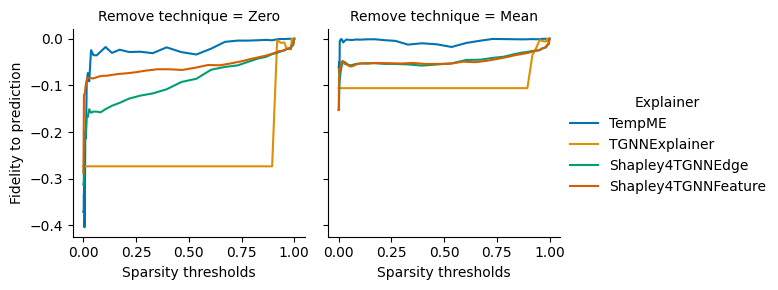

In [35]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_curve.png", bbox_inches='tight')

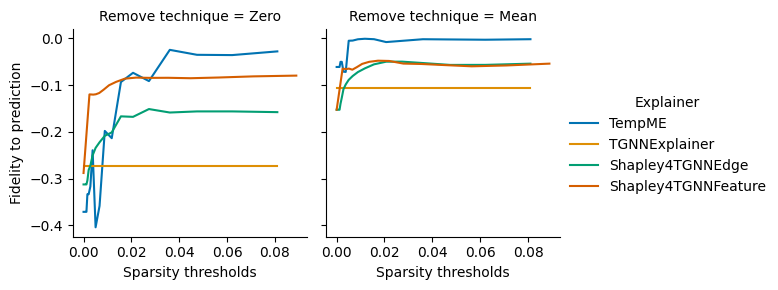

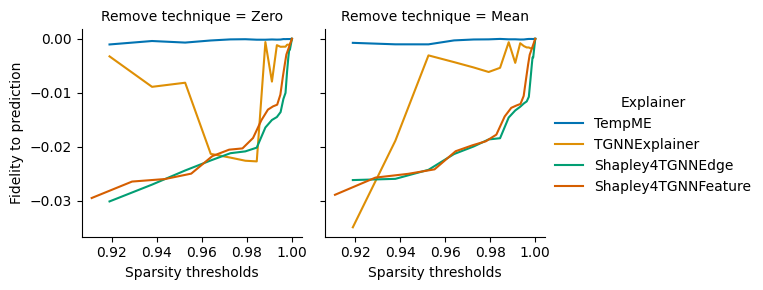

In [36]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_curve_upper_part.png", bbox_inches='tight')
plt.show()

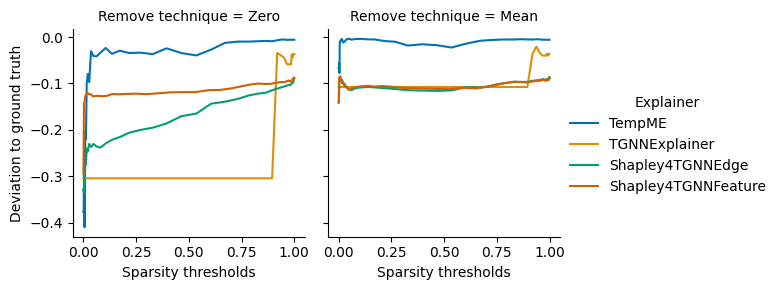

In [37]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Deviation to ground truth")
g.add_legend()
g.savefig("Documents/Images/Reddit/Deviation_curve.png", bbox_inches='tight')

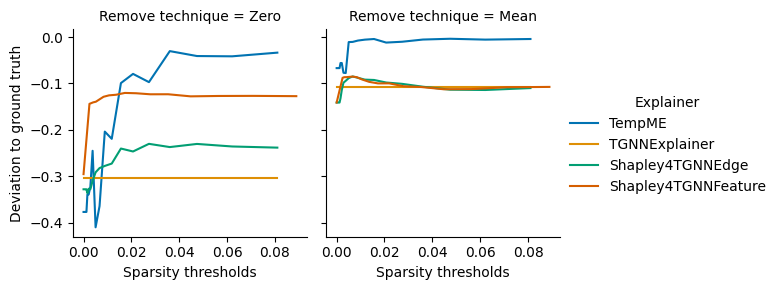

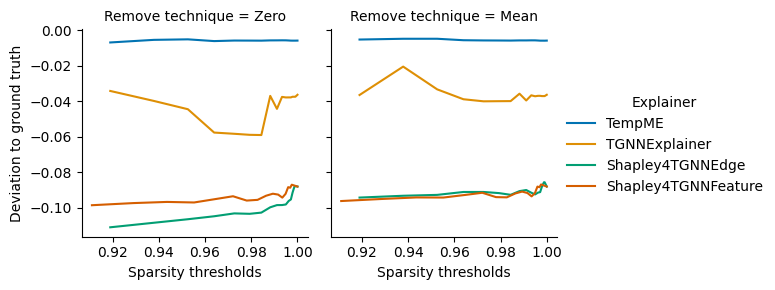

In [38]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Deviation to ground truth")
g.add_legend()
g.savefig("Documents/Images/Reddit/Deviation_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Deviation to ground truth")
g.add_legend()
g.savefig("Documents/Images/Reddit/Deviation_curve_upper_part.png", bbox_inches='tight')
plt.show()

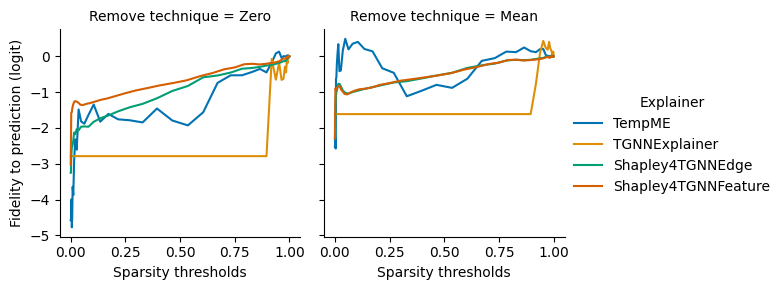

In [39]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction (logit)")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_logit_curve.png", bbox_inches='tight')

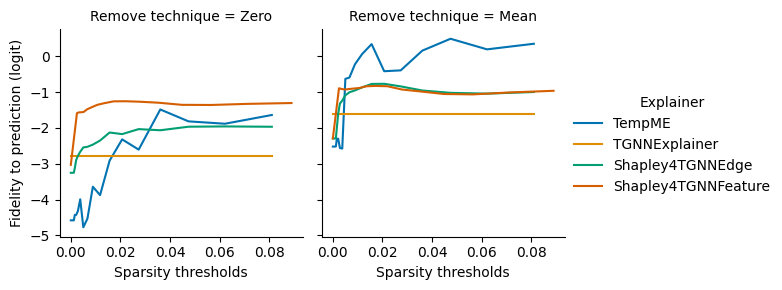

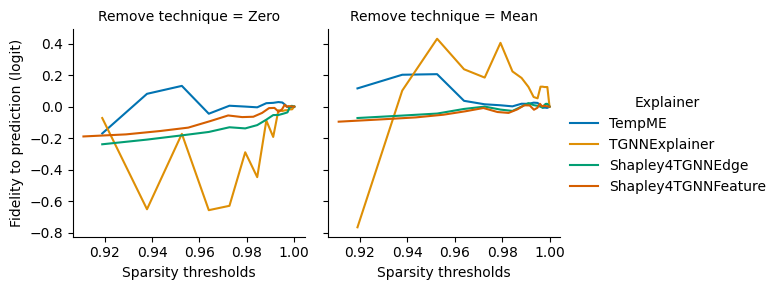

In [40]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction (logit)")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_logit_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="Fidelity to prediction (logit)")
g.add_legend()
g.savefig("Documents/Images/Reddit/Fid_logit_curve_upper_part.png", bbox_inches='tight')
plt.show()

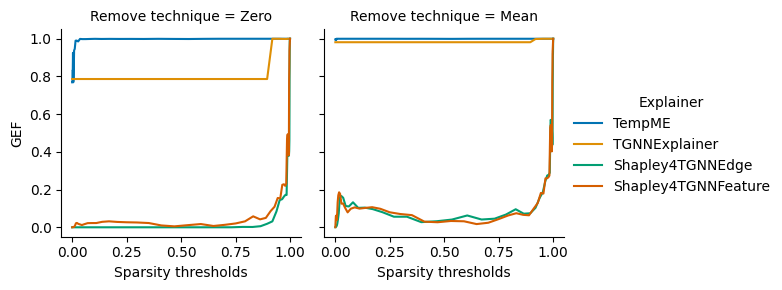

In [41]:
g = sns.FacetGrid(df, col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="GEF")
g.add_legend()
g.savefig("Documents/Images/Reddit/GEF_curve.png", bbox_inches='tight')

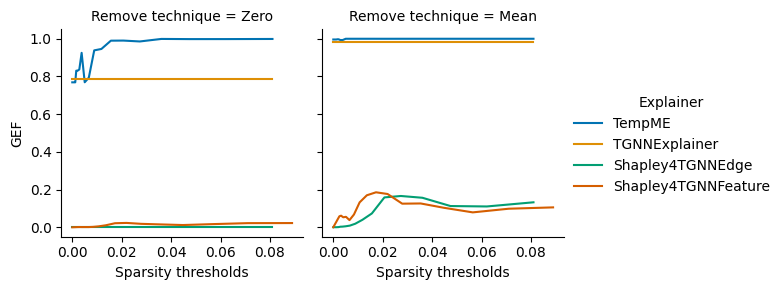

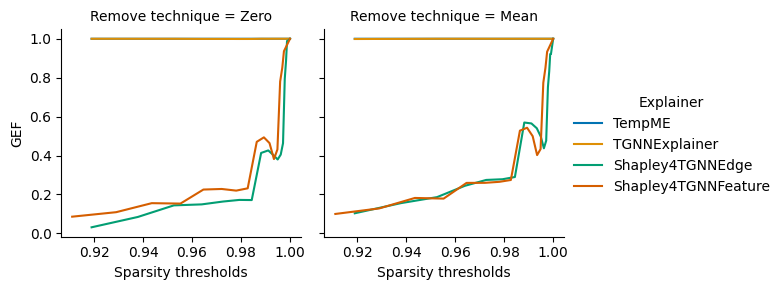

In [42]:
g = sns.FacetGrid(df[df["Sparsity thresholds"]<=0.1], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="GEF")
g.add_legend()
g.savefig("Documents/Images/Reddit/GEF_curve_lower_part.png", bbox_inches='tight')

g = sns.FacetGrid(df[df["Sparsity thresholds"]>=0.9], col="Remove technique", hue="Explainer", legend_out=True, palette=PALLETTE2)
g.map_dataframe(sns.lineplot, x="Sparsity thresholds", y="GEF")
g.add_legend()
g.savefig("Documents/Images/Reddit/GEF_curve_upper_part.png", bbox_inches='tight')
plt.show()

## AUCs

In [43]:
from Explainers.utils import calc_auc

auc_fid_log_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction (logit)", "Zero")
auc_fid_log_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction (logit)", "Mean")
auc_fid_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction", "Zero")
auc_fid_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Fidelity to prediction", "Mean")
auc_dev_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Deviation to ground truth", "Zero")
auc_dev_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "Deviation to ground truth", "Mean")
auc_gef_zero = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "GEF", "Zero")
auc_gef_mean = calc_auc([result_tempme,result_tgnnexpl, result_shapley_edge,result_shapley_feat], "GEF", "Mean")

print(f"AUC for Fidelity (logit) using Zero: {auc_fid_log_zero}")
print(f"AUC for Fidelity (logit) using Mean: {auc_fid_log_mean}")
print("")
print(f"AUC for Fidelity using Zero: {auc_fid_zero}")
print(f"AUC for Fidelity using Mean: {auc_fid_mean}")
print("")
print(f"AUC for Deviation using Zero: {auc_dev_zero}")
print(f"AUC for Deviation using Mean: {auc_dev_mean}")
print("")
print(f"AUC for GEF: {auc_gef_zero}")
print(f"AUC for GEF: {auc_gef_mean}")

text_zero=f"""
\\parbox[t]{{5mm}}{{\\multirow{{4}}{{*}}{{\\rotatebox[origin=c]{{90}}{{Reddit}}}}}} & TGNN Explainer & {round(auc_fid_zero[1],4)} & {round(auc_fid_log_zero[1],4)} & {round(auc_dev_zero[1],4)} & {round(auc_gef_zero[1],4)} \\\\
& TempME & {round(auc_fid_zero[0],4)} & {round(auc_fid_log_zero[0],4)} & {round(auc_dev_zero[0],4)} & {round(auc_gef_zero[0],4)} \\\\
& Shapley (Event) & {round(auc_fid_zero[2],4)} & {round(auc_fid_log_zero[2],4)} & {round(auc_dev_zero[2],4)} & {round(auc_gef_zero[2],4)}\\\\
& Shapley (Feature) & {round(auc_fid_zero[3],4)} & {round(auc_fid_log_zero[3],4)} & {round(auc_dev_zero[3],4)} & {round(auc_gef_zero[3],4)}\\\\
"""

print(text_zero)

text_mean=f"""
\\parbox[t]{{5mm}}{{\\multirow{{4}}{{*}}{{\\rotatebox[origin=c]{{90}}{{Reddit}}}}}} & TGNN Explainer & {round(auc_fid_mean[1],4)} & {round(auc_fid_log_mean[1],4)} & {round(auc_dev_mean[1],4)} & {round(auc_gef_mean[1],4)} \\\\
& TempME & {round(auc_fid_mean[0],4)} & {round(auc_fid_log_mean[0],4)} & {round(auc_dev_mean[0],4)} & {round(auc_gef_mean[0],4)} \\\\
& Shapley (Event) & {round(auc_fid_mean[2],4)} & {round(auc_fid_log_mean[2],4)} & {round(auc_dev_mean[2],4)} & {round(auc_gef_mean[2],4)} \\\\
& Shapley (Feature) & {round(auc_fid_mean[3],4)} & {round(auc_fid_log_mean[3],4)} & {round(auc_dev_mean[3],4)} & {round(auc_gef_mean[3],4)} \\\\
"""

print(text_mean)

AUC for Fidelity (logit) using Zero: [np.float64(3.4900391873610346), np.float64(2.215947302593179), np.float64(3.8008332606937176), np.float64(4.079853788002425)]
AUC for Fidelity (logit) using Mean: [np.float64(4.484171941037229), np.float64(3.3117622334900445), np.float64(4.287611565007077), np.float64(4.289849682700766)]

AUC for Fidelity using Zero: [np.float64(0.3813738563507724), np.float64(0.15524539201748036), np.float64(0.31371092649745363), np.float64(0.34499487012676655)]
AUC for Fidelity using Mean: [np.float64(0.39865848703424045), np.float64(0.306972335617079), np.float64(0.35762349281867456), np.float64(0.3573387414338622)]

AUC for Deviation using Zero: [np.float64(0.38141180810207714), np.float64(0.12981627966289117), np.float64(0.24118008995614215), np.float64(0.2952669114205773)]
AUC for Deviation using Mean: [np.float64(0.3997972006374447), np.float64(0.30941243060639245), np.float64(0.3030907392951598), np.float64(0.3046600601124755)]

AUC for GEF: [np.float64(0.9

## Timings

In [44]:
timings = np.concat(timings)
df_timings = pd.DataFrame(timings, columns=["Time", "Explainer", "Action"])

In [45]:
df_timings.loc[:,"Time"] = df_timings.Time.astype(float)/1000000

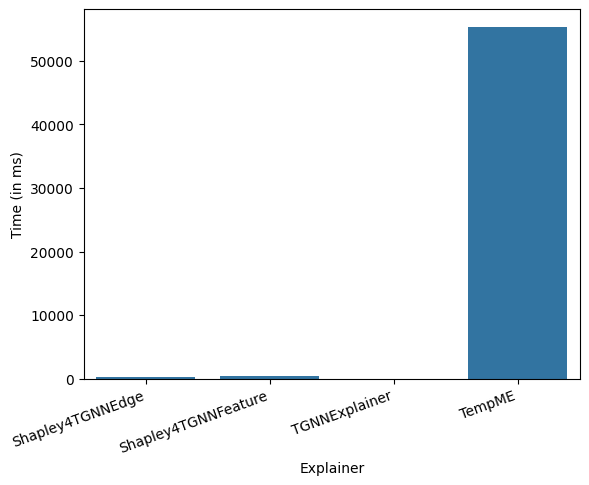

In [46]:
import matplotlib.pyplot as plt

p = sns.barplot(df_timings[df_timings.Action=="Init"], y="Time", x="Explainer", color=PRIMARYCOLOR)
p.set(ylabel="Time (in ms)", )
plt.xticks(rotation=20, horizontalalignment='right')
p.get_figure().savefig("Documents/Images/Reddit/Timings_init.png", bbox_inches='tight')

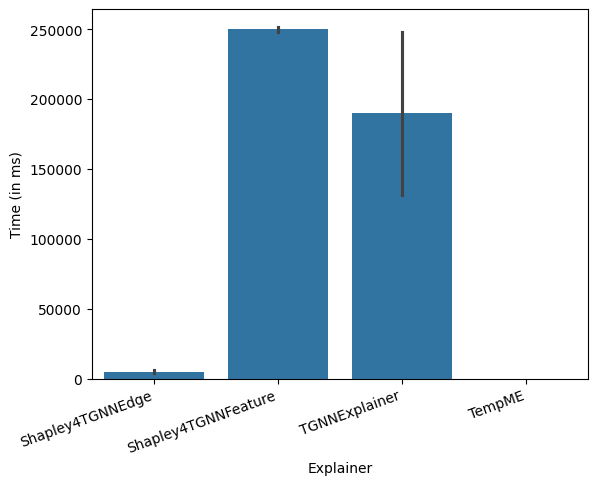

In [47]:
p = sns.barplot(df_timings[df_timings.Action=="Explain"], y="Time", x="Explainer", color=PRIMARYCOLOR)
p.set(ylabel="Time (in ms)", )
plt.xticks(rotation=20, horizontalalignment='right')
p.get_figure().savefig("Documents/Images/Reddit/Timings_expl.png", bbox_inches='tight')